In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
from sklearn.manifold import TSNE

import os
from glob import glob
from hashlib import sha1
from itertools import islice
import random
from pathlib import Path
import multiprocessing

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import XformerEstimator
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, DeviceStatsMonitor, EarlyStopping

2023-11-15 00:13:54.620696: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 00:13:54.665570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
dataset = get_dataset("traffic")

In [5]:
seed = 0
experiment_name = "xformer"
fulldir = experiment_name + "/" + str(seed)
os.makedirs(fulldir, exist_ok=True)


# Code to retrieve the version with the highest #epoch stored and restore it incl directory and its checkpoint
lightning_version_to_use, ckpt_path = None, None
max_epoch = -1
if "xformer" in os.listdir(fulldir):
    ckpts = glob(fulldir+ sha1(fulldir.encode("utf-8")).hexdigest()[:8] + "/checkpoints/*.ckpt")
    if len(ckpts): ckpt_path = ckpts[0]
elif "lightning_logs" in os.listdir(fulldir):
    for lightning_version in os.listdir(fulldir+"/lightning_logs/"):
        ckpts = glob(fulldir+"/lightning_logs/" + lightning_version + "/checkpoints/*.ckpt")
        if len(ckpts):
            epoch = int(ckpts[0][ckpts[0].find("=")+1:ckpts[0].find("-step")])
            if epoch > max_epoch:
                lightning_version_to_use = lightning_version
                max_epoch = epoch
                ckpt_path = ckpts[0]
    if lightning_version_to_use: print("Using lightning_version", lightning_version_to_use, "with epoch", max_epoch, "restoring from checkpoint at path", ckpt_path)


experiment_logger = CSVLogger(save_dir=fulldir)
logger = [experiment_logger]
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=50, verbose=True, mode="min")
callbacks=[early_stop_callback]

Using lightning_version version_6 with epoch 49 restoring from checkpoint at path xformer/0/lightning_logs/version_6/checkpoints/epoch=49-step=5000.ckpt


In [6]:
estimator = XformerEstimator(
        # freq=dataset.metadata.freq,
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*6,
        
        scaling=True,
        # num_feat_static_cat=len(dataset.metadata.feat_static_cat),
        # cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
        # embedding_dimension=[5],
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        hidden_layer_multiplier=1,
        activation="gelu",

#         # longformer
        # attention_args={"name": "global",},
        # reversible=True, 
        attention_args={"name": "nystrom",},
        # favor/performer
        # attention_args={"name": "favor", "iter_before_redraw": 2},
        # attention_args={"name": "linformer", "iter_before_redraw": 2},
        batch_size=256,
        num_batches_per_epoch=100,
        trainer_kwargs=dict(max_epochs=50, accelerator='gpu', devices=1, logger=logger, callbacks=callbacks),
        ckpt_path = ckpt_path    
)

In [7]:
predictor = estimator.train(
        training_data=dataset.train,
    validation_data=dataset.test,
        shuffle_buffer_length=1024,
        # num_workers=8,
        # cache_data=True,
    ckpt_path = ckpt_path
    )


/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/xformers/factory/model_factory.py:105: FutureWarning: xFormerConfig(stack_configs=[xFormerEncoderConfig(dim_model=64, feedforward_config=MlpConfig(name='MLP', dim_model=64, dropout=0.1, activation='gelu', hidden_layer_multiplier=1, bias=None), position_encoding_config=PositionEmbeddingConfig(name='sine', dim_model=64, seq_len=None), block_type=<BlockType.Encoder: 'encoder'>, residual_norm_style=<ResidualNormStyle.Pre: 'pre'>, normalization=<NormalizationType.LayerNorm: 'layernorm'>, layer_position=<xformers.factory.block_configs.LayerPosition object at 0x7fad08f307f0>, use_triton=True, reversible=False, num_layers=4, multi_head_config={'use_rotary_embeddings': False, 'num_heads': 2, 'residual_dropout': 0.1, 'attention': {'name': 'nystrom', 'dropout': 0.1, 'causal': False, 'seq_len': 144, 'num_rules': 2}, 'dim_model': 64}, simplicial_embeddings=None, patch_embedding_config=None)], tie_embedding_weights=False, weight_init=<xForme

Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/xformers/factory/model_factory.py:105: FutureWarning: xFormerConfig(stack_configs=[xFormerEncoderConfig(dim_model=64, feedforward_config=MlpConfig(name='MLP', dim_model=64, dropout=0.1, activation='gelu', hidden_layer_multiplier=1, bias=None), position_encoding_config=PositionEmbeddingConfig(name='sine', dim_model=64, seq_len=None), block_type=<BlockType.Encoder: 'encoder'>, residual_norm_style=<ResidualNormStyle.Pre: 'pre'>, normalization=<NormalizationType.LayerNorm: 'layernorm'>, layer_position=<xformers.factory.block_configs.LayerPosition object at 0x7fad08fdb220>, use_triton=True, reversible=False, num_layers=4, multi_head_config={'use_rotary_embeddings': False, 'num_heads': 2, 'residual_dropout': 0.1, 'attention': {'name': 'nystrom', 'dropout': 0.1, 'causal': False, 'seq_len': 144, 'num_rules': 2}, 'dim_model': 64}, simplicial_embeddings=None, patch_embedding_config=None)], 

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [9]:
forecasts = list(forecast_it)

In [10]:
tss = list(ts_it)

In [11]:
num_workers = min(multiprocessing.cpu_count(), 10)

evaluator = Evaluator(num_workers=num_workers)

In [12]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 6034it [00:00, 18300.80it/s]
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/ccs/proj/csc499/hstellar/py38/lib/python3.8/site-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [13]:
agg_metrics

{'MSE': 0.0009380217476525621,
 'abs_error': 2845.889135159552,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 1.509641749636905,
 'MAPE': 0.7674997953104885,
 'sMAPE': 0.3793426657318015,
 'MSIS': 10.72368077791173,
 'QuantileLoss[0.1]': 996.935220683861,
 'Coverage[0.1]': 0.4536377195889957,
 'QuantileLoss[0.2]': 1827.1937405956298,
 'Coverage[0.2]': 0.7584106728538283,
 'QuantileLoss[0.3]': 2402.496018555644,
 'Coverage[0.3]': 0.86898547121865,
 'QuantileLoss[0.4]': 2726.376217920333,
 'Coverage[0.4]': 0.9172881449563585,
 'QuantileLoss[0.5]': 2845.889134296798,
 'Coverage[0.5]': 0.9420298862004198,
 'QuantileLoss[0.6]': 2748.149480076507,
 'Coverage[0.6]': 0.9559440945751851,
 'QuantileLoss[0.7]': 2529.615644242848,
 'Coverage[0.7]': 0.9675035907634516,
 'QuantileLoss[0.8]': 2128.7705151841974,
 'Coverage[0.8]': 0.9767014694508893,
 'QuantileLoss[0.9]': 1479.4156202696263,
 'Coverage[0.9]': 0.98538144956

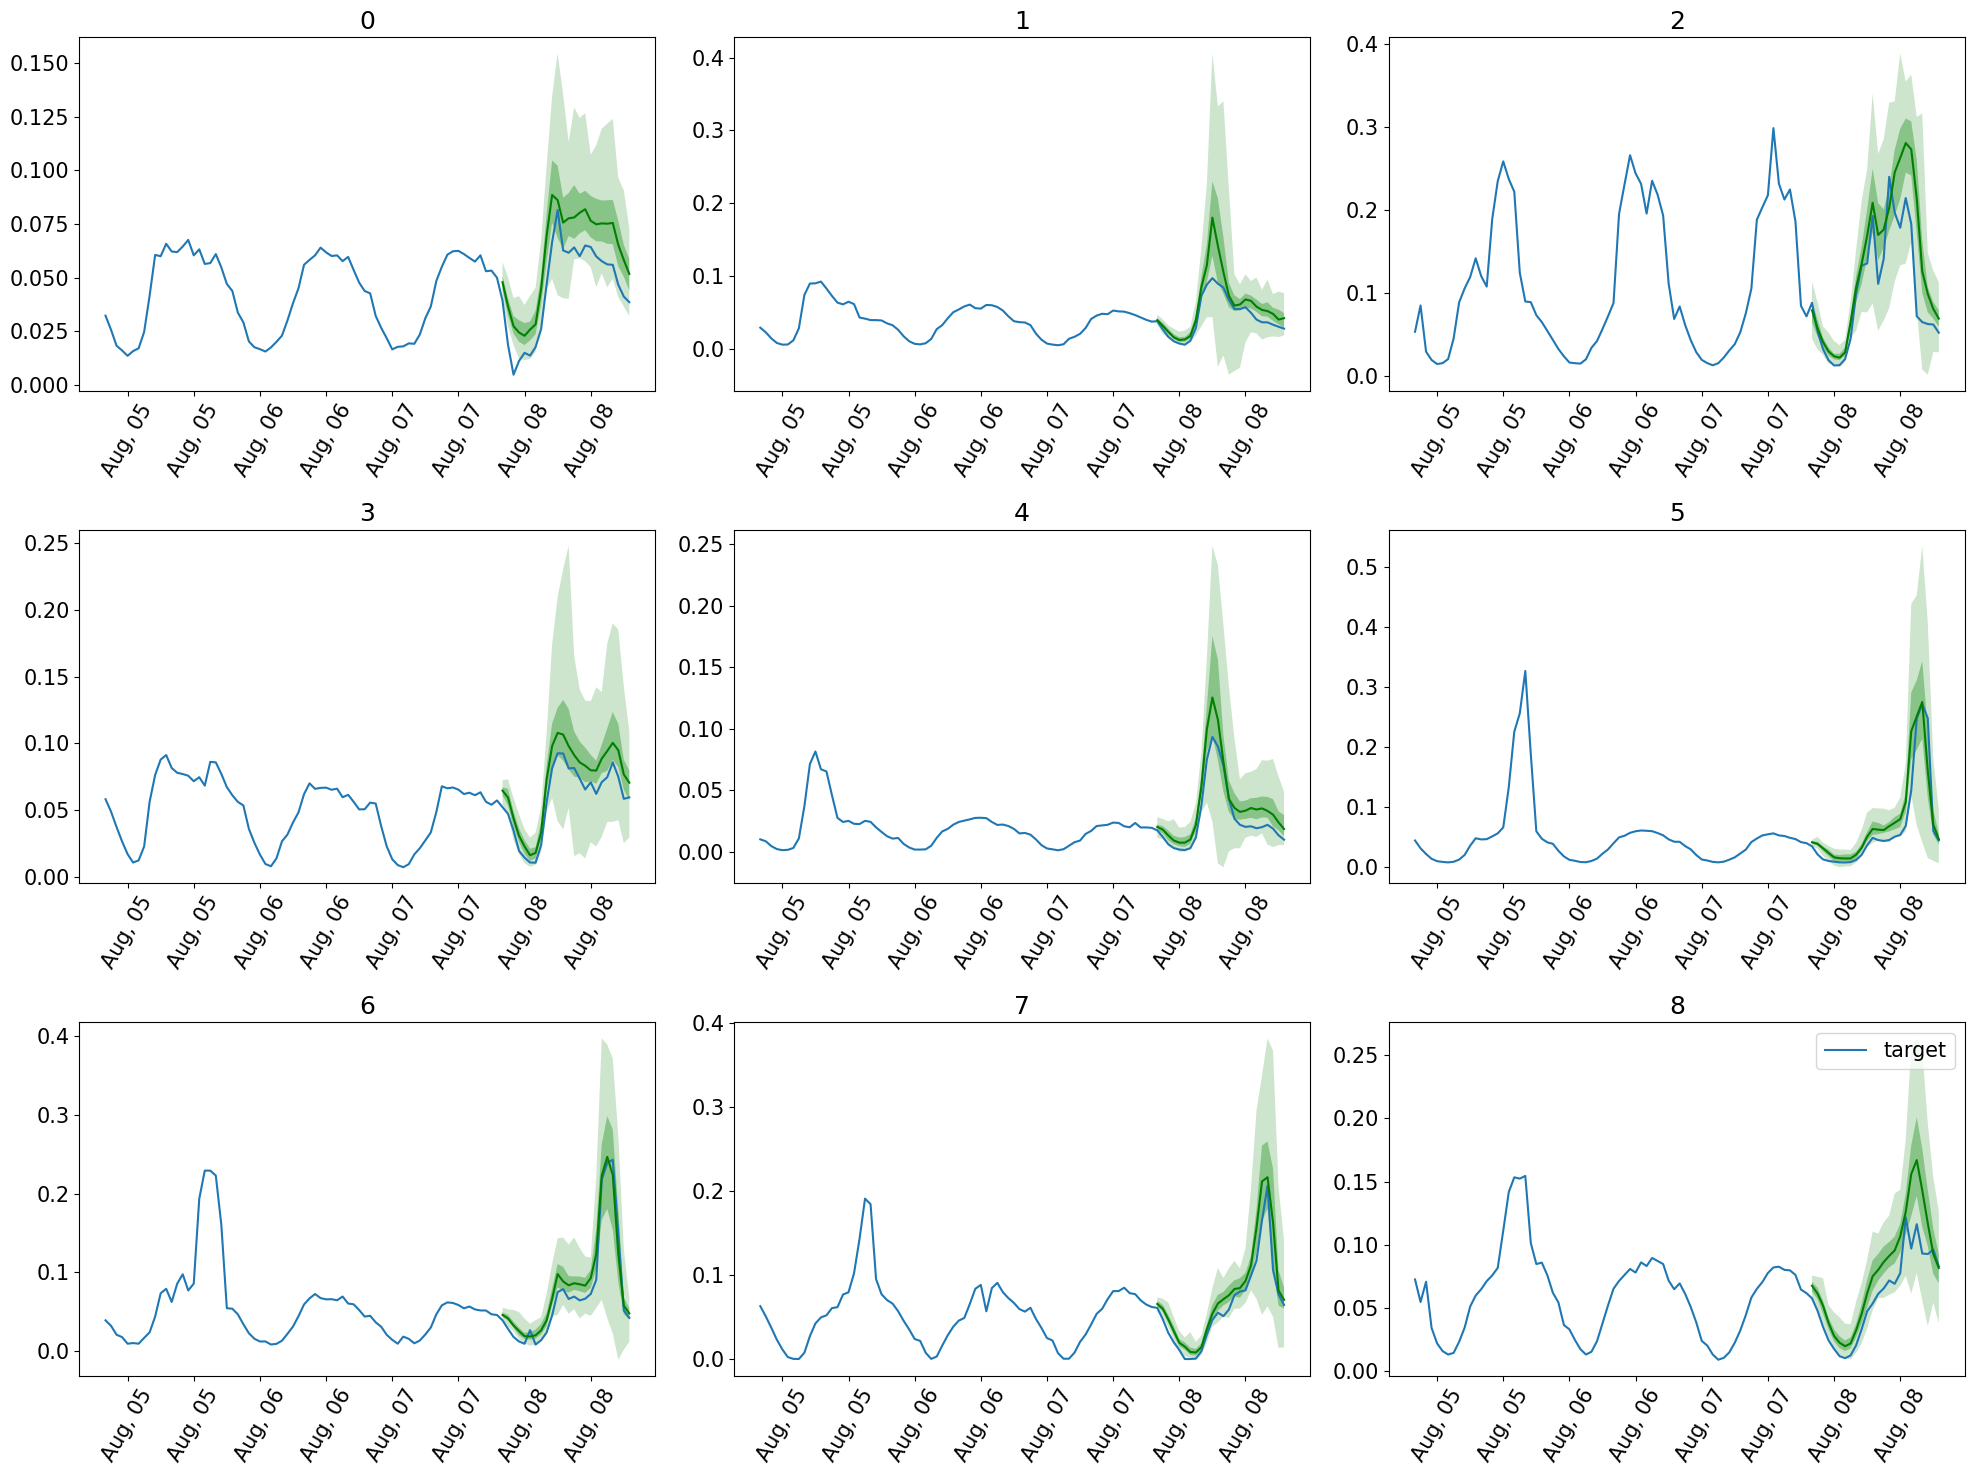

In [15]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [18]:
metrics = pd.read_csv("lightning_logs/version_86/metrics.csv")

In [19]:
metrics

,train_perplexity,epoch,step,val_loss,train_loss
0,2.042362,0,49,NaN,NaN
1,2.050069,0,99,NaN,NaN
2,2.743227,0,149,NaN,NaN
3,2.440984,0,199,NaN,NaN
4,NaN,0,199,4.355846,NaN
...,...,...,...,...,...
295,80.659866,49,9899,NaN,NaN
296,82.568138,49,9949,NaN,NaN
297,81.211136,49,9999,NaN,NaN
298,NaN,49,9999,1.084462,NaN


Text(0, 0.5, 'perplexity')

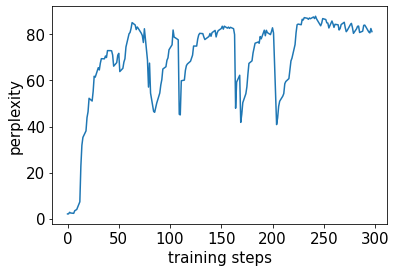

In [20]:
ax = metrics.train_perplexity.dropna().plot(kind="line")
ax.set_xlabel("training steps")
ax.set_ylabel("perplexity")

Text(0, 0.5, 'val neg. log likelihood')

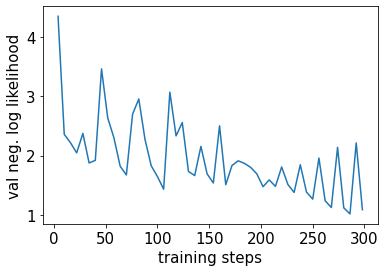

In [21]:
ax = metrics.val_loss.dropna().plot()
ax.set_xlabel("training steps")
ax.set_ylabel("val neg. log likelihood")

In [22]:
X = predictor.prediction_net.vq_vae.embed.cpu()

In [23]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

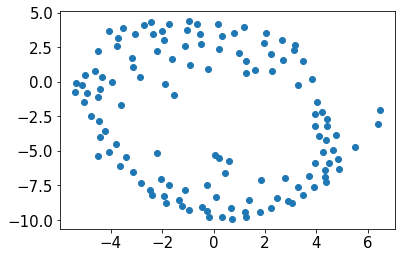

In [24]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=1.0)